# Upload data to Colab

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

**You'll be prompted for your google credentials after running next cell**

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

Assume you have file named `data.zip` on your google drive.

In [4]:
example_file_name = 'train_test_data.zip'
example_file_id = get_file_id(example_file_name)

In [5]:
move_from_drive_to_disk([example_file_name], ['train_test_data.zip'])

Downloaded 104857601/212781105 bytes
Downloaded 209715202/212781105 bytes
Downloaded 212781105/212781105 bytes


In [6]:
!unzip train_test_data.zip
!rm train_test_data.zip
!mv train_test_data data

Archive:  train_test_data.zip
   creating: train_test_data/
   creating: train_test_data/dt05_bth/
  inflating: train_test_data/dt05_bth/F01_050C0103_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0105_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010C_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010G_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010J_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010K_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010L_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010O_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010P_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010R_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010U_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010W_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0112_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0116_BTH.C

# Program

In [1]:
%matplotlib inline

! pip install -q librosa nltk

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import librosa
import glob

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['image.cmap'] = 'hot'

Using TensorFlow backend.


In [0]:
def read_audio(path, sample_rate):
    mono, _ = librosa.load(path, sr=sample_rate, mono=True)
    return np.expand_dims(mono, 1)

def fake_stereo(audio):
    stereo = audio[:, 0]
    return np.stack((stereo, stereo), axis=1)

def compute_spectrogram(audio, n_fft, fft_hop):
    
    def stft(x):
        spec = librosa.stft(
            x, n_fft=n_fft, hop_length=fft_hop, window='hann')
     
        return np.abs(spec), np.angle(spec)
    
    def mono_func(py_audio):
        mag, phase = stft(py_audio[:, 0])
        ret = np.array([mag, phase]).T
        return ret.astype(np.float32)
    
    ret = mono_func(audio)
    np.reshape(ret, (-1, 1 + n_fft // 2, 2))
    return ret

def extract_spectrogram_patches(spec, n_fft, patch_window, patch_hop):
    spec4d = np.expand_dims(spec, axis=0)

    patches = tf.extract_image_patches(
        images=spec4d,
        ksizes=[1, patch_window, 1 + n_fft / 2, 1],
        strides=[1, patch_hop, 1 + n_fft / 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    ).eval()

    num_patches = patches.shape[1]

    return np.reshape(patches, (num_patches, patch_window, int(1 + n_fft // 2), 2))

def partial_argv(func, *args, **kwargs):
    return lambda *other_args: tuple(map(partial(func, *args, **kwargs), other_args))

In [0]:
def training_dataset(
        pattern,
        sample_rate,
        n_fft,
        fft_hop,
        patch_window,
        patch_hop
):
    paths = sorted(glob.glob(pattern))
    audio = list(map(partial(read_audio, sample_rate=sample_rate), paths))
    stereo = list(map(fake_stereo, audio))
    spectrogram = list(map(partial(compute_spectrogram, n_fft=n_fft, fft_hop=fft_hop), stereo))
    with tf.Session() as sess:
        data = list(map(partial(extract_spectrogram_patches, n_fft=n_fft, patch_window=patch_window, patch_hop=patch_hop), spectrogram))
    
    return data

In [0]:
SAMPLE_RATE = 44100
N_FFT = 1024
FFT_HOP = 256
N_CHANNELS = 1  
N_PARALLEL_READERS = 4
PATCH_WINDOW = 256
PATCH_HOP = 128
BATCH_SIZE = 8
N_SHUFFLE = 20

In [0]:
voice = training_dataset('/content/data/dt05_bth/F01*.wav', SAMPLE_RATE, N_FFT, FFT_HOP, PATCH_WINDOW, PATCH_HOP)
mixed = training_dataset('/content/data/dt05_bus_simu/F01*.wav', SAMPLE_RATE, N_FFT, FFT_HOP, PATCH_WINDOW, PATCH_HOP)

In [6]:
print(len(voice))
print(len(mixed))
print(voice[1].shape)
print(mixed[1].shape)

103
103
(7, 256, 513, 2)
(7, 256, 513, 2)


In [0]:
def roll(arr,shift):
    shape = arr.shape
    arr = arr.reshape(shape[0]*shape[1],shape[2],shape[3])
    arr = np.roll(arr, shift, axis=0)
    return arr.reshape(shape[0],shape[1],shape[2],shape[3])

In [0]:
voice = list(map(partial(roll,shift=-4), voice))

# Test

In [0]:
voice = np.vstack(voice)
mixed = np.vstack(mixed)

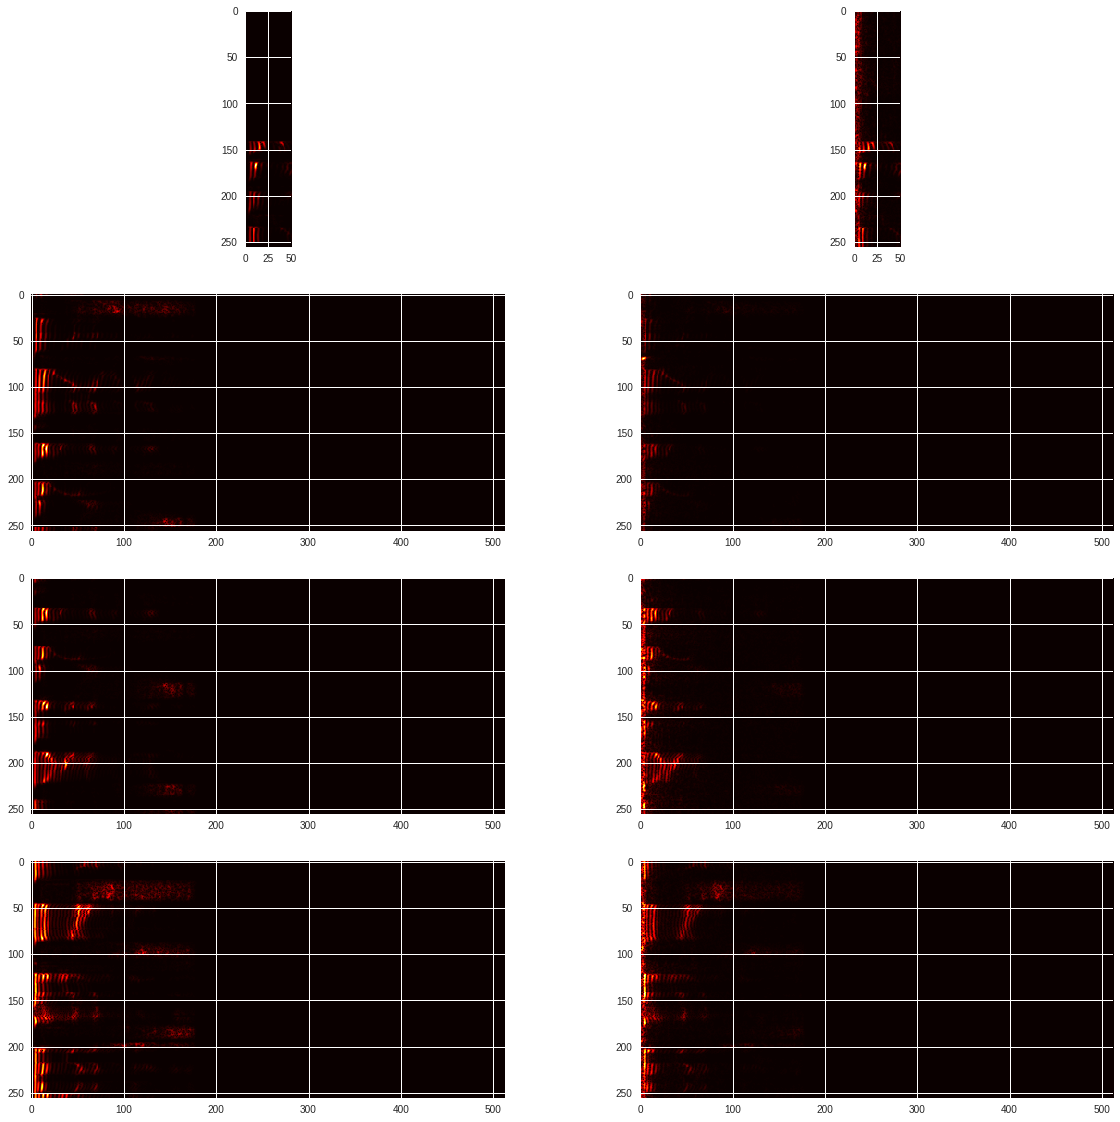

In [10]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,20))
ax1.imshow(voice[14, :, :50, 0])
ax2.imshow(mixed[14, :, :50, 0])
ax3.imshow(voice[1, :, :, 0])
ax4.imshow(mixed[1, :, :, 0])
ax5.imshow(voice[2, :, :, 0])
ax6.imshow(mixed[2, :, :, 0])
ax7.imshow(voice[490, :, :, 0])
ax8.imshow(mixed[490, :, :, 0])

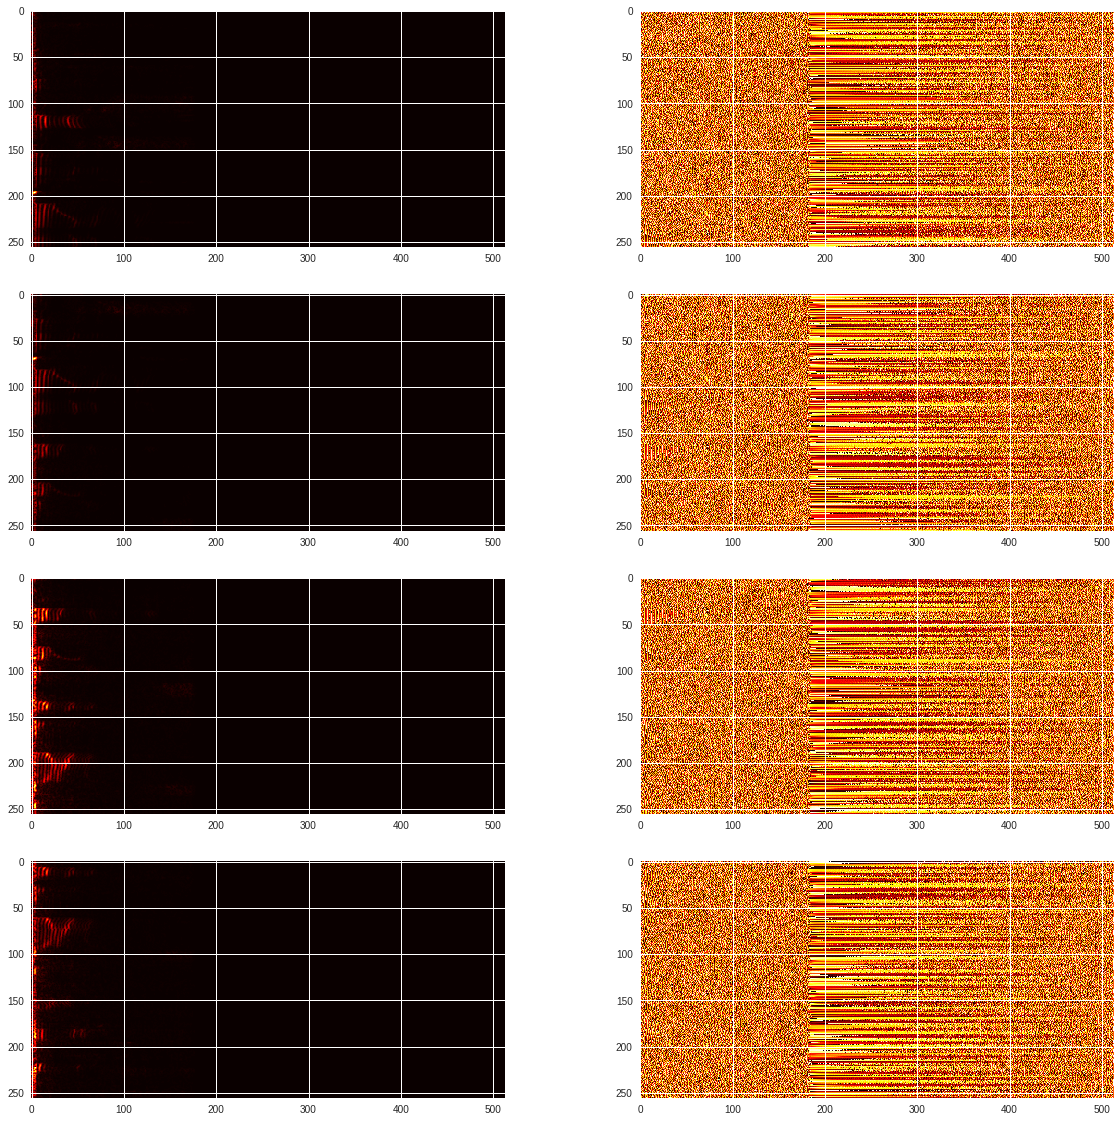

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,20))
ax1.imshow(mixed[0, :, :, 0])
ax2.imshow(mixed[0, :, :, 1])
ax3.imshow(mixed[1, :, :, 0])
ax4.imshow(mixed[1, :, :, 1])
ax5.imshow(mixed[2, :, :, 0])
ax6.imshow(mixed[2, :, :, 1])
ax7.imshow(mixed[3, :, :, 0])
ax8.imshow(mixed[3, :, :, 1])

In [0]:
train_voice = voice[:,:,:512,:1]
train_mixed = mixed[:,:,:512,:1]

In [14]:
print(train_mixed.shape)
print(train_voice.shape)

(785, 256, 512, 1)
(785, 256, 512, 1)


In [0]:
input_size = (256, 512, 1)
inputs = Input(input_size)
conv1 = Conv2D(16, 5, strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(32, 5, strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(64, 5, strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(128, 5, strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(256, 5, strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(512, 5, strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Deconv2D(256, 5, strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = Activation('relu')(deconv7)

deconv8 = Concatenate(axis=3)([deconv7, conv5])
deconv8 = Deconv2D(128, 5, strides=2, padding='same')(deconv8)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = Activation('relu')(deconv8)

deconv9 = Concatenate(axis=3)([deconv8, conv4])
deconv9 = Deconv2D(64, 5, strides=2, padding='same')(deconv9)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = Activation('relu')(deconv9)

deconv10 = Concatenate(axis=3)([deconv9, conv3])
deconv10 = Deconv2D(32, 5, strides=2, padding='same')(deconv10)
deconv10 = BatchNormalization()(deconv10)
deconv10 = Activation('relu')(deconv10)

deconv11 = Concatenate(axis=3)([deconv10, conv2])
deconv11 = Deconv2D(16, 5, strides=2, padding='same')(deconv11)
deconv11 = BatchNormalization()(deconv11)
deconv11 = Activation('relu')(deconv11)

deconv12 = Concatenate(axis=3)([deconv11, conv1])
deconv12 = Deconv2D(1, 5, strides=2, padding='same')(deconv12)
deconv12 = Activation('relu')(deconv12)

model = Model(inputs=inputs, outputs=deconv12)

model.compile(optimizer=Adam(1e-4), loss='mean_absolute_error')

In [16]:
model.fit(train_mixed, train_voice, batch_size=4,epochs=5)

Epoch 1/5
785/785 [==============================] - 21s 26ms/step - loss: 0.1281
Epoch 2/5
785/785 [==============================] - 17s 22ms/step - loss: 0.0937
Epoch 3/5
785/785 [==============================] - 17s 22ms/step - loss: 0.0861
Epoch 4/5
785/785 [==============================] - 17s 22ms/step - loss: 0.0819
Epoch 5/5
785/785 [==============================] - 17s 22ms/step - loss: 0.0785


In [0]:
model.fit(train_mixed, train_voice, epochs=10, validation_split=0.2, verbose=2)

In [0]:
voice_pred = model.predict(train_mixed[:4, :, :, :])

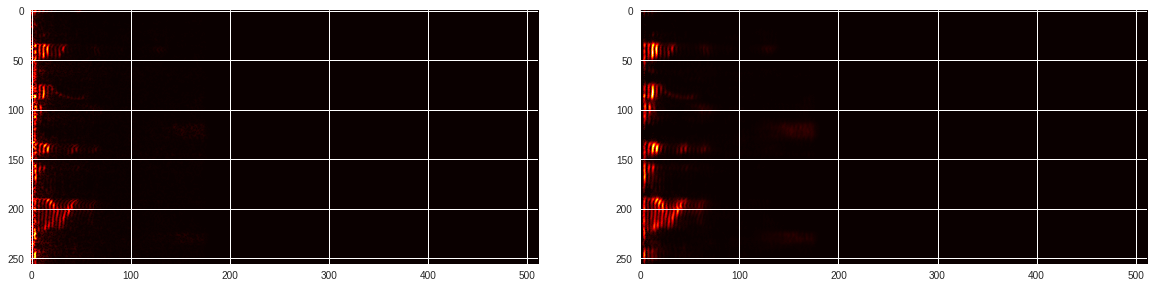

In [20]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(train_mixed[2, :, :, 0])
ax2.imshow(voice_pred[2, :, :, 0])

In [28]:
import tensorflow as tf

n = 10
# images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100 in order
images = [[[[x * n + y + 1] for y in range(n)] for x in range(n)]]

# We generate four outputs as follows:
# 1. 3x3 patches with stride length 5
# 2. Same as above, but the rate is increased to 2
# 3. 4x4 patches with stride length 7; only one patch should be generated
# 4. Same as above, but with padding set to 'SAME'
with tf.Session() as sess:
  print(tf.extract_image_patches(images=images, ksizes=[1, 4, 10, 1], strides=[1, 2, 10, 1], rates=[1, 1, 1, 1], padding='VALID').eval())
  

[[[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
     35  36  37  38  39  40]]

  [[ 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
     38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
     55  56  57  58  59  60]]

  [[ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
     58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
     75  76  77  78  79  80]]

  [[ 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
     78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
     95  96  97  98  99 100]]]]
